# Online Regression with Synthetic dataset

* In machine learning theory, thera are two well known learning approaches: **online learning** and **offline learning**.


* Here the meanings of two terms, "online" and "offline", are slightly different to what we use in our daily lives. Usually we use both terms to refer to the status of network: if a device is connected to the Internet, it's called "online", while "offline" if it's not.


* However, in machine learning, a model tries to learn some "relationship" between the source and the target from given data.
    - For example, in linear regression, the model tries to learn(or estimate) the parameter $\beta$ such that satisfies $Y = X\beta + \epsilon$.
    - Likewise, a neural network model tries to learn a set of weights and biases such that maps $X$ to $Y$.


* The meaning of "online" and "offline" are also defined in this sense.
    - Specifically, if a model updates its parameters(or learns) **sequentially** as each data point comes in, this method is called as **online learning**.
    - On the other hand, if a model updates the parameters only after **observing every given data point**, then that method is called as **offline learning**.
    
    
* To get it simple, it is also might be okay to think like:
    - learning with batch size **1** is equivalent to online learning
    - learning with batch size **$N$** is equivalent to offline learning, where $N$ denotes the total number of observations in the given dataset.
    
    
* In this notebook, I'm going to conduct a multiple linear regression experiment with a synthetic dataset, and compare the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from tqdm.auto import tqdm
from IPython.display import display, HTML

display(HTML("<style>.container { width:75% !important; }</style>"))
%matplotlib inline

In [2]:
## Define some utility functions

def l1norm(v:np.ndarray):
    v = v.flatten()
    return np.sum(abs(v))


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    else:
        rnd = np.random.gamma(2, size=d*d).reshape(d,d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v:np.ndarray, dim:Union[int, tuple]):
    if type(dim) == int:
        diag = np.zeros((dim, dim))
        rng = dim
    else:
        diag = np.zeros(dim)
        rng = min(dim)
        
    for i in range(rng):
        diag[i, i] = v[i]
    
    return diag


def positive_definite_generator(dimension:int, distribution:str):
    d = dimension
    ## create orthogonal eigenvectors
    if distribution == "gaussian":
        source = np.random.randn(d,d)
    elif distribution == "uniform":
        source = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    else:
        source = np.random.gamma(shape=1.5, size=d*d).reshape(d, d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0., 2., size=d)
    eigmat = make_diagonal(np.absolute(eigvals), len(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def rademacher(size:int):
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, random_state:int, std:float=None):
    np.random.seed(random_state)
    if not std:
        assert distribution in ["gaussian", "uniform", "rademacher"], "Distribution must be one of: 'gaussian', 'uniform', or 'rademacher'."
    
    if distribution == "gaussian":
        if not std:
            std = 1.
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if not std:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

* The codes below will be used to generate synthetic datasets.
    - The `feature_sampler` function generates a set of features of shape $(N, d)$, where $N$ denotes the number of observations, and $d$ denotes the dimension of each feature. For convenience, I'm going to use either Gaussian or Uniform distribution.
    - The `param_generator` function generates a regression parameter vector from a specific distribution.

In [3]:
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, random_state:int, cov_dist:str=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert feat_dist.lower() in ["gaussian", "uniform"], "Distribution must be either 'gaussian' or 'uniform'."
    
    if disjoint:
        if feat_dist.lower() == "gaussian":
            ## gaussian
            feat = np.random.multivariate_normal(mean=np.ones(dimension), cov=np.identity(dimension), size=size)
        else:
            ## uniform
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)
    else:
        assert cov_dist is not None, "Please pass the distribution to sample the covariance matrix: 'gaussian' or 'uniform'."
        if feat_dist.lower() == "gaussian":
            ## gaussian
            cov = covariance_generator(dimension, distribution=cov_dist)
            feat = np.random.multivariate_normal(mean=np.ones(dimension), cov=cov, size=size)
        else:
            ## uniform
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)

            # Cholesky decomposition
            pd = positive_definite_generator(dimension, distribution=cov_dist)
            L = np.linalg.cholesky(pd)
            for i in range(size):
                feat[i, :] = L @ feat[i, :]
    
    return feat


def param_generator(dimension:int, distribution:str, disjoint:bool, random_state:int, bound:float=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform", "gamma"]
    
    if disjoint:
        if distribution == "gaussian":
            param = np.random.randn(dimension)
        elif distribution == "uniform":
            param = np.random.uniform(low=-1., high=1., size=dimension)
        else:
            param = np.random.gamma(shape=2., size=dimension)
    else:
        if distribution == "gaussian":
            cov = covariance_generator(dimension, distribution=distribution)
            param = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov)
        elif distribution == "uniform":
            pd = positive_definite_generator(dimension, distribution=distribution)
            param = np.random.uniform(low=-1., high=1., size=dimension)
            L = np.linalg.cholesky(pd)
            param = L @ param
        else:
            pd = positive_definite_generator(dimension, distribution=distribution)
            param = np.random.gamma(shape=1., size=dimension)
            L = np.linalg.cholesky(pd)
            param = L @ param
                    
    if (bound is not None) and (l2norm(param) > bound): 
        param *= (bound / l2norm(param))
    
    return param

In [4]:
def mean_squared_error(y_true:np.ndarray, y_pred:np.ndarray):
    squared_error = (y_true - y_pred) ** 2
    return np.mean(squared_error)

In [5]:
## hyperparameters
d = 10
training_samples, test_samples = 100000, 20000
seed = 237

## $X={(x_{ij})}_{i=1,j=1}^{N,d}\sim U(-1, 1), \epsilon_i\sim N(0,1), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim U(-1,1)$

Shape of X: (120000, 11)
First observation: [ 1.          0.97561731 -0.52256163 -0.97208453  0.63756872 -0.67875967
  0.95924509  0.16444417  0.0542513  -0.15121154  0.23673119]


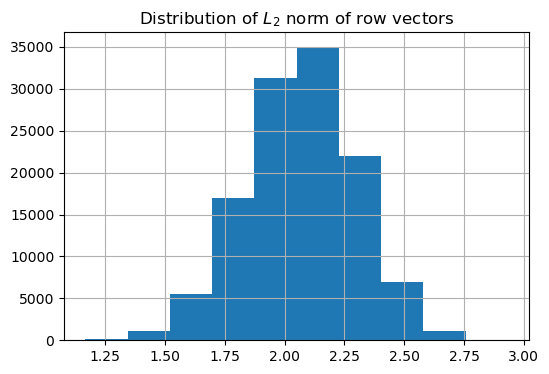

In [6]:
## Generate X
X = feature_sampler(dimension=d, feat_dist="uniform", disjoint=True, size=training_samples+test_samples, random_state=seed)
C = np.ones(training_samples+test_samples) ## add constant term
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [7]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="uniform", disjoint=True, random_state=seed)
print(f"beta: {beta}")

beta: [ 0.97561731 -0.52256163 -0.97208453  0.63756872 -0.67875967  0.95924509
  0.16444417  0.0542513  -0.15121154  0.23673119 -0.63144079]


In [8]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=1.)
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (120000,), standard deviation: 1.0
First five epsilons: [ 0.8297433   2.51508173  1.89927194 -1.2131559  -0.58484597]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (120000,)
First 10 labels: [ 0.07307295  4.0607576   3.33904838  0.15313721  0.02419427 -0.86872878
  1.38570731  1.15359559 -0.33436376  0.19062877]


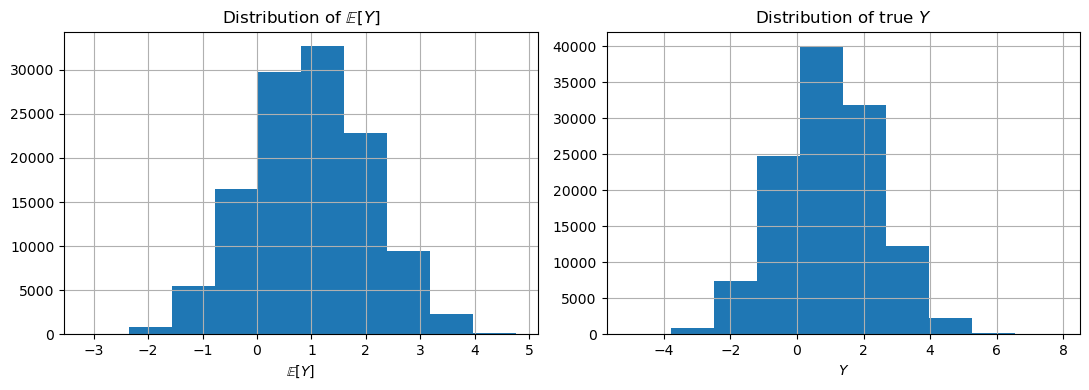

In [9]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [10]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (20000, 11), (20000,)


## Offline approach

* First, we take one of the most well-known offline learning approach on linear regression, which is:
    - For a given features $X$ and the corresponding labels $y$,
    $$ \hat{\beta} = {\left(X^\top X\right)}^{-1}{X^\top y}$$

In [11]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Est.\t{offline_beta_hat}")
print(f"True\t{beta}")

Est.	[ 0.97383886 -0.51844871 -0.96656454  0.64424557 -0.67741577  0.95511744
  0.16034955  0.05549382 -0.14549371  0.23632028 -0.63557575]
True	[ 0.97561731 -0.52256163 -0.97208453  0.63756872 -0.67875967  0.95924509
  0.16444417  0.0542513  -0.15121154  0.23673119 -0.63144079]


In [12]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 1.005588


## Online approach

### Gradient Descent

* Here, I'm going to implement the Gradient Descent algorithm, setting the objective function(or loss function) as the mean squared error, where
$$ L_{\boldsymbol\beta} = \frac{1}{N}\sum_{i=1}^N {\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)}^2 $$


* Now, the gradient for each parameter for each point is:
    - For $\beta_0$: 
    $$\frac{\partial L_{\boldsymbol \beta}^i}{\partial \beta_0} = -2\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)$$
        - for any $i\in\{1,\dots, N\}$.
    - For $\beta_j$:
    $$\frac{\partial L_{\boldsymbol \beta}^i}{\partial \beta_j} = -2x_{ij}\cdot\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)$$
    

* So for each $i \in \{1, \dots, N\}$, the gradient descent function will implement:
$$
\begin{align*}
\beta_0^{\text{new}} &= \beta_0^{\text{old}} - \frac{\partial L_{\boldsymbol\beta}^i}{\beta_0}\\
\beta_j^{\text{new}} &= \beta_j^{\text{old}} - \frac{\partial L_{\boldsymbol\beta}^i}{\beta_j}.
\end{align*}
$$

In [13]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in tqdm(range(N)):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [14]:
EPOCHS = 10
online_beta_hat = np.zeros(d+1)
lr = 5e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 5e-05	Train loss: 1.22208	Test loss: 1.00827	Parameter distance: 0.07247


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 5e-05	Train loss: 1.00109	Test loss: 1.00586	Parameter distance: 0.02204


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02166


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00583	Parameter distance: 0.02165


In [15]:
print(f"True parameter:\n{beta.reshape(-1, 1)}")
print(f"Offline est.:\n{offline_beta_hat.reshape(-1, 1)}")
print(f"Online esti.:\n{online_beta_hat.reshape(-1, 1)}")

True parameter:
[[ 0.97561731]
 [-0.52256163]
 [-0.97208453]
 [ 0.63756872]
 [-0.67875967]
 [ 0.95924509]
 [ 0.16444417]
 [ 0.0542513 ]
 [-0.15121154]
 [ 0.23673119]
 [-0.63144079]]
Offline est.:
[[ 0.97383886]
 [-0.51844871]
 [-0.96656454]
 [ 0.64424557]
 [-0.67741577]
 [ 0.95511744]
 [ 0.16034955]
 [ 0.05549382]
 [-0.14549371]
 [ 0.23632028]
 [-0.63557575]]
Online esti.:
[[ 0.97090655]
 [-0.50661227]
 [-0.97125045]
 [ 0.64766818]
 [-0.67504771]
 [ 0.95632664]
 [ 0.16580566]
 [ 0.05711791]
 [-0.1464155 ]
 [ 0.2414098 ]
 [-0.63494863]]


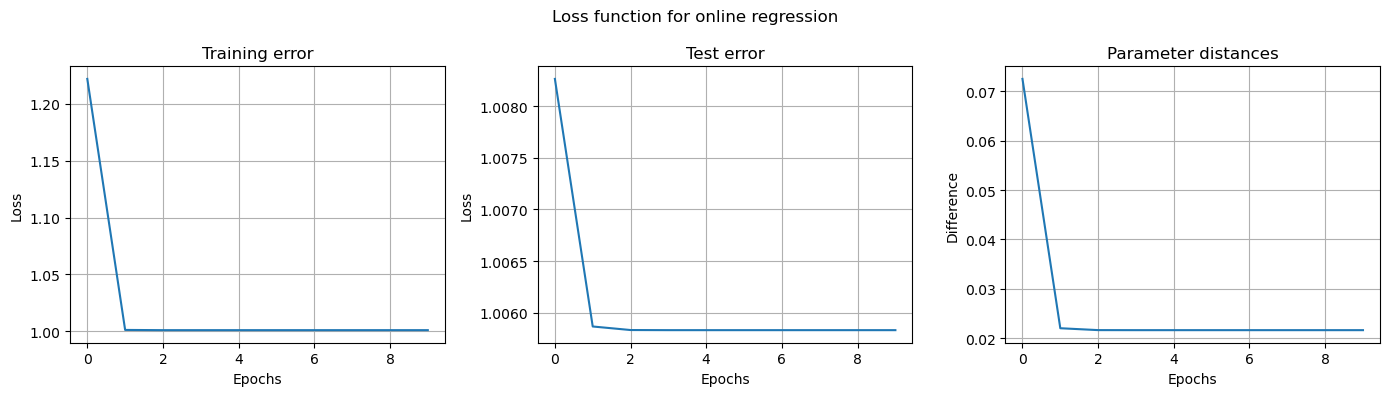

In [16]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle("Loss function for online regression")
plt.tight_layout()
plt.show()

### Batch learning - Stochastic Gradient Descent

* The below code implements the stochastic gradient descent, introducing the mini-batch approach.

In [17]:
def sgd(batch_size:int, lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Stochastic Graident descent for squared error
    N, dim = data.shape
    num_batches = int(np.ceil(N / batch_size))
    candidates = np.arange(N)
    loss = 0
    
    for _ in tqdm(range(num_batches)):
        try:
            indices = np.random.choice(candidates, size=batch_size, replace=False)
        except:
            ## remaining data
            indices = candidates
        X_batch, y_batch = data[indices], y_true[indices]
        batch_loss = 0
        bias_grads = 0
        weight_grads = np.zeros(params.shape)
        for i in range(len(indices)):
            row = X_batch[i, :]
            y_label = y_batch[i]
            y_pred = row @ params
            batch_loss += mean_squared_error(y_true=y_label, y_pred=y_pred)

            ## gradient update for the bias
            bias_grads += (2 * lr * (y_pred - y_label))

            ## gradient update for each weight
            for j in range(1, dim):
                weight_grads[j] += (2 * lr * (y_pred - y_label) * row[j])
        
        loss += batch_loss
        params[0] -= (bias_grads / batch_size)
        params[1:] -= (weight_grads[1:] / batch_size)
        
        ## remove the indices already used
        candidates = np.setdiff1d(candidates, indices)
    
    return params, (loss / (num_batches*batch_size))

### Batch size = 1

* In case of `batch_size=1`, the result must be equivalent(or at least similar) to that from the gradient descent.

In [18]:
EPOCHS = 10
online_beta_hat = np.zeros(d+1)
lr = 5e-5
batch_size = 1
print(f"Batch size: {batch_size}")

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = sgd(batch_size=batch_size, lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

Batch size: 1


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 5e-05	Train loss: 1.22189	Test loss: 1.00807	Parameter distance: 0.07232


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 5e-05	Train loss: 1.00101	Test loss: 1.00577	Parameter distance: 0.01725


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 5e-05	Train loss: 1.00083	Test loss: 1.00556	Parameter distance: 0.01819


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 5e-05	Train loss: 1.00086	Test loss: 1.00570	Parameter distance: 0.01199


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 5e-05	Train loss: 1.00088	Test loss: 1.00556	Parameter distance: 0.01771


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 5e-05	Train loss: 1.00082	Test loss: 1.00573	Parameter distance: 0.02453


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 5e-05	Train loss: 1.00077	Test loss: 1.00577	Parameter distance: 0.01771


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 5e-05	Train loss: 1.00089	Test loss: 1.00559	Parameter distance: 0.01854


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 5e-05	Train loss: 1.00085	Test loss: 1.00570	Parameter distance: 0.02154


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 5e-05	Train loss: 1.00085	Test loss: 1.00579	Parameter distance: 0.02472


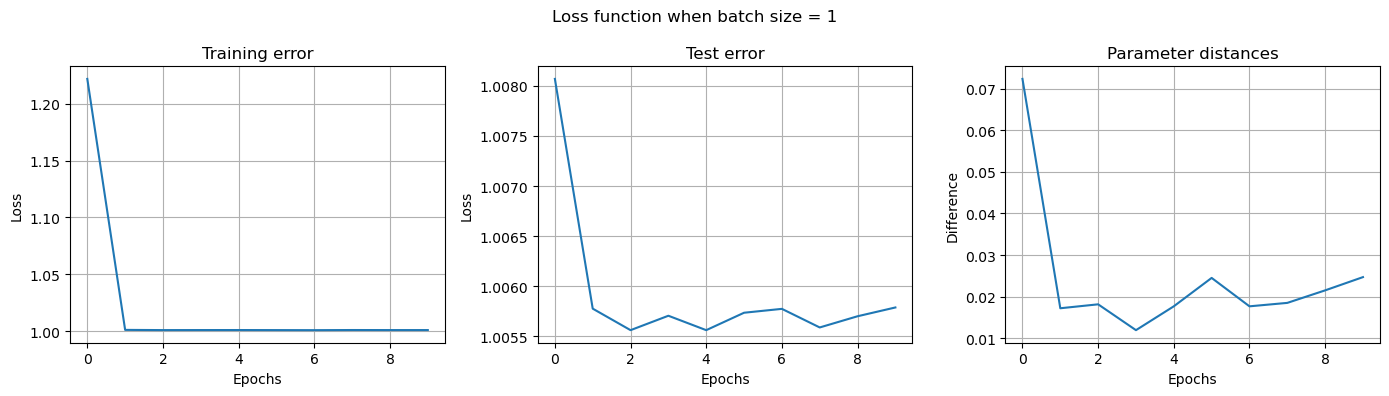

In [19]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle(f"Loss function when batch size = {batch_size}")
plt.tight_layout()
plt.show()

### Batch size = 256

In [20]:
EPOCHS = 25
online_beta_hat = np.zeros(d+1)
lr = 1e-5
batch_size = 256
print(f"Batch size: {batch_size}")

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = sgd(batch_size=batch_size, lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

Batch size: 256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 1e-05	Train loss: 3.10614	Test loss: 3.12470	Parameter distance: 2.10519


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 1e-05	Train loss: 3.08542	Test loss: 3.10410	Parameter distance: 2.09741


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 1e-05	Train loss: 3.06496	Test loss: 3.08376	Parameter distance: 2.08968


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 1e-05	Train loss: 3.04475	Test loss: 3.06368	Parameter distance: 2.08200


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 1e-05	Train loss: 3.02480	Test loss: 3.04384	Parameter distance: 2.07436


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 1e-05	Train loss: 3.00509	Test loss: 3.02425	Parameter distance: 2.06677


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 1e-05	Train loss: 2.98563	Test loss: 3.00490	Parameter distance: 2.05923


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 1e-05	Train loss: 2.96641	Test loss: 2.98580	Parameter distance: 2.05173


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 1e-05	Train loss: 2.94742	Test loss: 2.96692	Parameter distance: 2.04428


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 1e-05	Train loss: 2.92868	Test loss: 2.94828	Parameter distance: 2.03687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11]	Learning Rate: 1e-05	Train loss: 2.91016	Test loss: 2.92987	Parameter distance: 2.02951


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12]	Learning Rate: 1e-05	Train loss: 2.89187	Test loss: 2.91169	Parameter distance: 2.02219


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13]	Learning Rate: 1e-05	Train loss: 2.87381	Test loss: 2.89372	Parameter distance: 2.01491


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14]	Learning Rate: 1e-05	Train loss: 2.85596	Test loss: 2.87598	Parameter distance: 2.00768


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15]	Learning Rate: 1e-05	Train loss: 2.83834	Test loss: 2.85845	Parameter distance: 2.00049


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16]	Learning Rate: 1e-05	Train loss: 2.82093	Test loss: 2.84114	Parameter distance: 1.99334


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17]	Learning Rate: 1e-05	Train loss: 2.80374	Test loss: 2.82404	Parameter distance: 1.98624


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18]	Learning Rate: 1e-05	Train loss: 2.78675	Test loss: 2.80714	Parameter distance: 1.97918


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19]	Learning Rate: 1e-05	Train loss: 2.76997	Test loss: 2.79045	Parameter distance: 1.97215


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20]	Learning Rate: 1e-05	Train loss: 2.75339	Test loss: 2.77396	Parameter distance: 1.96517


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21]	Learning Rate: 1e-05	Train loss: 2.73702	Test loss: 2.75767	Parameter distance: 1.95823


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22]	Learning Rate: 1e-05	Train loss: 2.72084	Test loss: 2.74158	Parameter distance: 1.95133


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23]	Learning Rate: 1e-05	Train loss: 2.70486	Test loss: 2.72568	Parameter distance: 1.94447


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24]	Learning Rate: 1e-05	Train loss: 2.68906	Test loss: 2.70996	Parameter distance: 1.93765


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25]	Learning Rate: 1e-05	Train loss: 2.67346	Test loss: 2.69444	Parameter distance: 1.93087


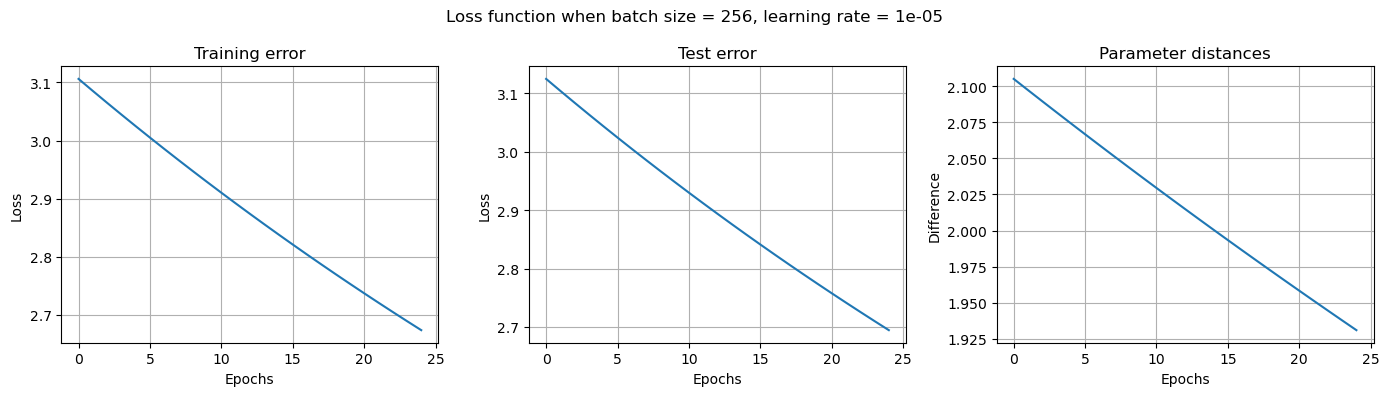

In [21]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle(f"Loss function when batch size = {batch_size}, learning rate = {lr}")
plt.tight_layout()
plt.show()

* As `batch_size` becomes larger, we need to increase the learning rate as well.

In [22]:
EPOCHS = 25
online_beta_hat = np.zeros(d+1)
lr = 3e-4
batch_size = 256
print(f"Batch size: {batch_size}")

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = sgd(batch_size=batch_size, lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

Batch size: 256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 0.0003	Train loss: 2.83822	Test loss: 2.61940	Parameter distance: 1.89749


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 0.0003	Train loss: 2.39693	Test loss: 2.25127	Parameter distance: 1.71563


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 0.0003	Train loss: 2.08519	Test loss: 1.98749	Parameter distance: 1.55973


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 0.0003	Train loss: 1.85962	Test loss: 1.79379	Parameter distance: 1.42412


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 0.0003	Train loss: 1.69234	Test loss: 1.64795	Parameter distance: 1.30462


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 0.0003	Train loss: 1.56534	Test loss: 1.53561	Parameter distance: 1.19819


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 0.0003	Train loss: 1.46677	Test loss: 1.44728	Parameter distance: 1.10258


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 0.0003	Train loss: 1.38877	Test loss: 1.37651	Parameter distance: 1.01607


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 0.0003	Train loss: 1.32597	Test loss: 1.31892	Parameter distance: 0.93736


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 0.0003	Train loss: 1.27471	Test loss: 1.27147	Parameter distance: 0.86544


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11]	Learning Rate: 0.0003	Train loss: 1.23238	Test loss: 1.23199	Parameter distance: 0.79951


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12]	Learning Rate: 0.0003	Train loss: 1.19714	Test loss: 1.19890	Parameter distance: 0.73895


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13]	Learning Rate: 0.0003	Train loss: 1.16761	Test loss: 1.17100	Parameter distance: 0.68323


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14]	Learning Rate: 0.0003	Train loss: 1.14272	Test loss: 1.14735	Parameter distance: 0.63187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15]	Learning Rate: 0.0003	Train loss: 1.12165	Test loss: 1.12724	Parameter distance: 0.58448


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16]	Learning Rate: 0.0003	Train loss: 1.10378	Test loss: 1.11010	Parameter distance: 0.54075


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17]	Learning Rate: 0.0003	Train loss: 1.08858	Test loss: 1.09546	Parameter distance: 0.50036


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18]	Learning Rate: 0.0003	Train loss: 1.07564	Test loss: 1.08293	Parameter distance: 0.46304


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19]	Learning Rate: 0.0003	Train loss: 1.06460	Test loss: 1.07221	Parameter distance: 0.42856


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20]	Learning Rate: 0.0003	Train loss: 1.05517	Test loss: 1.06301	Parameter distance: 0.39668


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21]	Learning Rate: 0.0003	Train loss: 1.04712	Test loss: 1.05511	Parameter distance: 0.36719


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22]	Learning Rate: 0.0003	Train loss: 1.04024	Test loss: 1.04833	Parameter distance: 0.33993


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23]	Learning Rate: 0.0003	Train loss: 1.03436	Test loss: 1.04250	Parameter distance: 0.31473


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24]	Learning Rate: 0.0003	Train loss: 1.02934	Test loss: 1.03750	Parameter distance: 0.29143


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25]	Learning Rate: 0.0003	Train loss: 1.02504	Test loss: 1.03319	Parameter distance: 0.26989


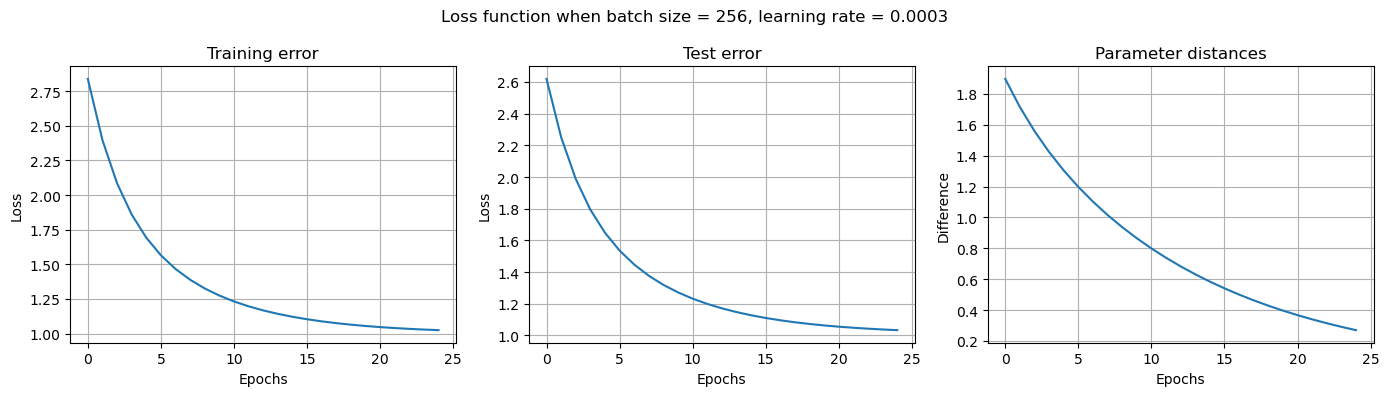

In [23]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle(f"Loss function when batch size = {batch_size}, learning rate = {lr}")
plt.tight_layout()
plt.show()

In [24]:
print(f"True parameter:\n{beta.reshape(-1, 1)}")
print(f"Offline est.:\n{offline_beta_hat.reshape(-1, 1)}")
print(f"Online esti.:\n{online_beta_hat.reshape(-1, 1)}")

True parameter:
[[ 0.97561731]
 [-0.52256163]
 [-0.97208453]
 [ 0.63756872]
 [-0.67875967]
 [ 0.95924509]
 [ 0.16444417]
 [ 0.0542513 ]
 [-0.15121154]
 [ 0.23673119]
 [-0.63144079]]
Offline est.:
[[ 0.97383886]
 [-0.51844871]
 [-0.96656454]
 [ 0.64424557]
 [-0.67741577]
 [ 0.95511744]
 [ 0.16034955]
 [ 0.05549382]
 [-0.14549371]
 [ 0.23632028]
 [-0.63557575]]
Online esti.:
[[ 0.97166044]
 [-0.44607049]
 [-0.82999257]
 [ 0.55144552]
 [-0.58053733]
 [ 0.81820159]
 [ 0.13743958]
 [ 0.04645071]
 [-0.12398384]
 [ 0.20507778]
 [-0.54605629]]


## $X=\frac{1}{2}(A+B), A=(a_{ij})\sim U(-2, 2), B\sim N(\boldsymbol{1}_d, \Sigma_d), \epsilon_i\sim N(0,2), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim N(0,1)$

Shape of X: (120000, 11)
First observation: [ 1.          2.27495181 -0.2522507  -0.06329362  2.67276683 -0.78030946
 -0.21492262 -0.45454299 -0.61053662 -0.70718013  0.57108308]


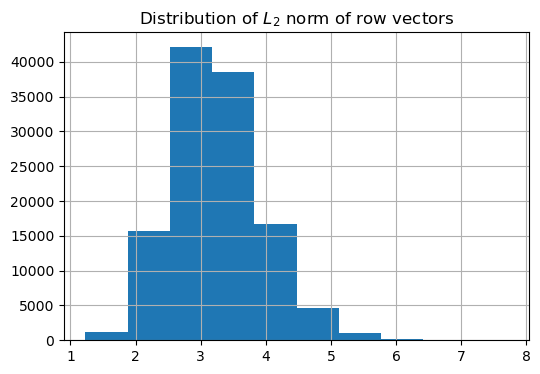

In [25]:
## Generate X
A = feature_sampler(dimension=d, feat_dist="uniform", disjoint=True, size=training_samples+test_samples, random_state=seed, uniform_rng=[-2., 2.])
B = feature_sampler(dimension=d, feat_dist="gaussian", disjoint=False, size=training_samples+test_samples, random_state=seed, cov_dist="uniform")
X = (A + B) * 0.5
C = np.ones(training_samples+test_samples) ## add constant term
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [26]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="gamma", disjoint=True, random_state=seed)
print(f"beta: {beta}")

beta: [2.98374062 7.47859227 1.0199097  0.79572764 1.14110845 1.04862198
 1.55698955 3.18385651 0.56406601 0.79253703 2.96907266]


In [27]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=np.sqrt(2))
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (120000,), standard deviation: 1.4142135623730951
First five epsilons: [ 1.17343422  3.55686269  2.68597613 -1.71566152 -0.8270971 ]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (120000,)
First 10 labels: [22.10354748 25.4384207  -2.38437521 14.0617763   3.73293284 16.11617116
 12.31043285 14.54753015  0.40924005 12.4576338 ]


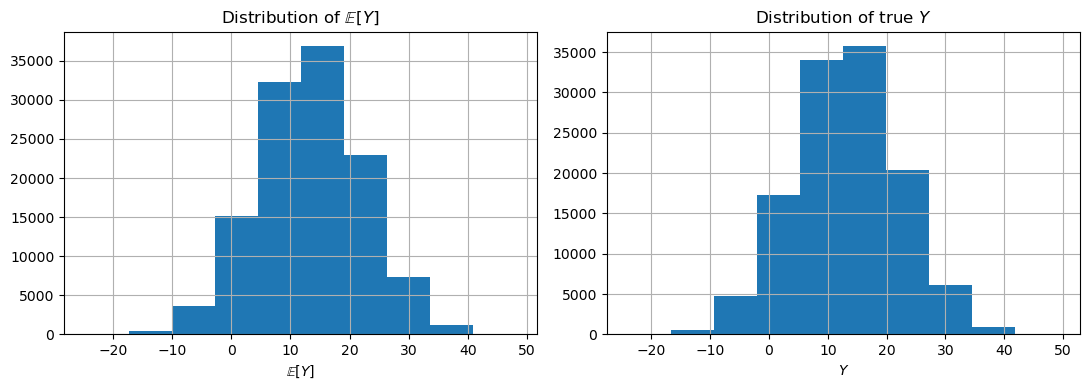

In [28]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [29]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (20000, 11), (20000,)


## Offline approach

* First, we take one of the most well-known offline learning approach on linear regression, which is:
    - For a given features $X$ and the corresponding labels $y$,
    $$ \hat{\beta} = {\left(X^\top X\right)}^{-1}{X^\top y}$$

In [30]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Est.\t{offline_beta_hat}")
print(f"True\t{beta}")

Est.	[2.96850113 7.48418266 1.02322214 0.79892071 1.14439073 1.04320259
 1.55186668 3.19251997 0.57233126 0.79942788 2.96576899]
True	[2.98374062 7.47859227 1.0199097  0.79572764 1.14110845 1.04862198
 1.55698955 3.18385651 0.56406601 0.79253703 2.96907266]


In [31]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 2.011398


## Online approach

### Gradient Descent

* Here, I'm going to implement the Gradient Descent algorithm, setting the objective function(or loss function) as the mean squared error, where
$$ L_{\boldsymbol\beta} = \frac{1}{N}\sum_{i=1}^N {\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)}^2 $$


* Now, the gradient for each parameter for each point is:
    - For $\beta_0$: 
    $$\frac{\partial L_{\boldsymbol \beta}^i}{\partial \beta_0} = -2\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)$$
        - for any $i\in\{1,\dots, N\}$.
    - For $\beta_j$:
    $$\frac{\partial L_{\boldsymbol \beta}^i}{\partial \beta_j} = -2x_{ij}\cdot\left(y_i - \beta_0 - \sum_{j=1}^d \beta_i x_{ij}\right)$$
    

* So for each $i \in \{1, \dots, N\}$, the gradient descent function will implement:
$$
\begin{align*}
\beta_0^{\text{new}} &= \beta_0^{\text{old}} - \frac{\partial L_{\boldsymbol\beta}^i}{\beta_0}\\
\beta_j^{\text{new}} &= \beta_j^{\text{old}} - \frac{\partial L_{\boldsymbol\beta}^i}{\beta_j}.
\end{align*}
$$

In [32]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in tqdm(range(N)):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [33]:
EPOCHS = 25
online_beta_hat = np.zeros(d+1)
lr = 1e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 1e-05	Train loss: 24.22096	Test loss: 2.96332	Parameter distance: 1.49644


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 1e-05	Train loss: 2.43991	Test loss: 2.18178	Parameter distance: 0.70038


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 1e-05	Train loss: 2.09221	Test loss: 2.05098	Parameter distance: 0.36268


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 1e-05	Train loss: 2.02455	Test loss: 2.02134	Parameter distance: 0.20400


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 1e-05	Train loss: 2.00836	Test loss: 2.01389	Parameter distance: 0.12474


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 1e-05	Train loss: 2.00394	Test loss: 2.01185	Parameter distance: 0.08149


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 1e-05	Train loss: 2.00252	Test loss: 2.01126	Parameter distance: 0.05527


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 1e-05	Train loss: 2.00197	Test loss: 2.01110	Parameter distance: 0.03806


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 1e-05	Train loss: 2.00171	Test loss: 2.01108	Parameter distance: 0.02654


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 1e-05	Train loss: 2.00158	Test loss: 2.01111	Parameter distance: 0.01938


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [11]	Learning Rate: 1e-05	Train loss: 2.00151	Test loss: 2.01116	Parameter distance: 0.01596


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [12]	Learning Rate: 1e-05	Train loss: 2.00147	Test loss: 2.01121	Parameter distance: 0.01538


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [13]	Learning Rate: 1e-05	Train loss: 2.00144	Test loss: 2.01126	Parameter distance: 0.01631


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [14]	Learning Rate: 1e-05	Train loss: 2.00143	Test loss: 2.01129	Parameter distance: 0.01771


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [15]	Learning Rate: 1e-05	Train loss: 2.00142	Test loss: 2.01133	Parameter distance: 0.01911


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [16]	Learning Rate: 1e-05	Train loss: 2.00142	Test loss: 2.01135	Parameter distance: 0.02033


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [17]	Learning Rate: 1e-05	Train loss: 2.00142	Test loss: 2.01137	Parameter distance: 0.02133


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [18]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01139	Parameter distance: 0.02214


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [19]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01140	Parameter distance: 0.02278


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [20]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01141	Parameter distance: 0.02328


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [21]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01142	Parameter distance: 0.02367


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [22]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01142	Parameter distance: 0.02397


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [23]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01143	Parameter distance: 0.02420


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [24]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01143	Parameter distance: 0.02437


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch [25]	Learning Rate: 1e-05	Train loss: 2.00141	Test loss: 2.01143	Parameter distance: 0.02451


In [34]:
print(f"True parameter:\n{beta.reshape(-1, 1)}")
print(f"Offline est.:\n{offline_beta_hat.reshape(-1, 1)}")
print(f"Online esti.:\n{online_beta_hat.reshape(-1, 1)}")

True parameter:
[[2.98374062]
 [7.47859227]
 [1.0199097 ]
 [0.79572764]
 [1.14110845]
 [1.04862198]
 [1.55698955]
 [3.18385651]
 [0.56406601]
 [0.79253703]
 [2.96907266]]
Offline est.:
[[2.96850113]
 [7.48418266]
 [1.02322214]
 [0.79892071]
 [1.14439073]
 [1.04320259]
 [1.55186668]
 [3.19251997]
 [0.57233126]
 [0.79942788]
 [2.96576899]]
Online esti.:
[[2.9673076 ]
 [7.48556599]
 [1.02018018]
 [0.7995695 ]
 [1.14261899]
 [1.04331836]
 [1.55074993]
 [3.19262133]
 [0.57246977]
 [0.79938843]
 [2.96718286]]


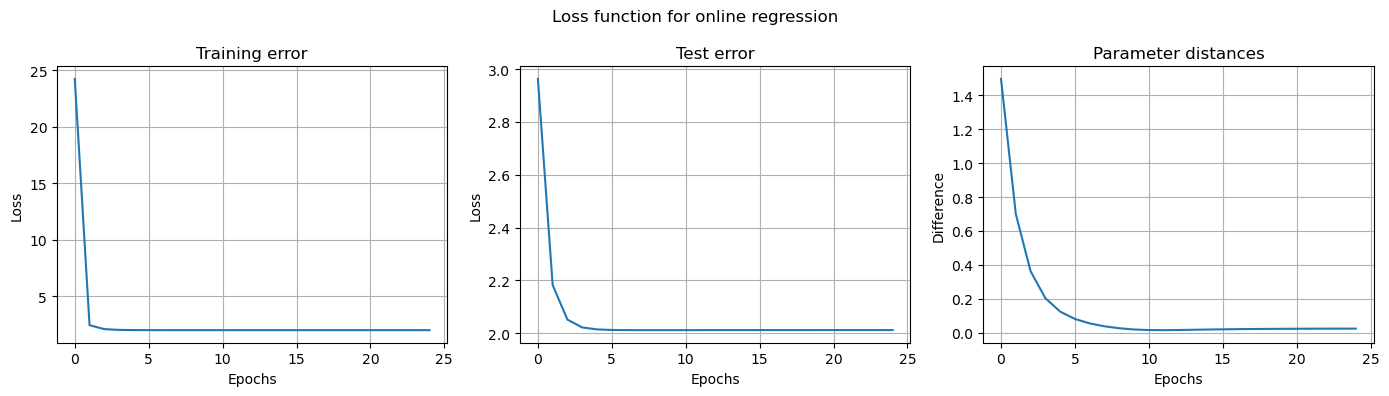

In [35]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle("Loss function for online regression")
plt.tight_layout()
plt.show()

### Batch learning - Stochastic Gradient Descent

* The below code implements the stochastic gradient descent, introducing the mini-batch approach.

In [36]:
def sgd(batch_size:int, lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Stochastic Graident descent for squared error
    N, dim = data.shape
    num_batches = int(np.ceil(N / batch_size))
    candidates = np.arange(N)
    loss = 0
    
    for _ in tqdm(range(num_batches)):
        try:
            indices = np.random.choice(candidates, size=batch_size, replace=False)
        except:
            ## remaining data
            indices = candidates
        X_batch, y_batch = data[indices], y_true[indices]
        batch_loss = 0
        bias_grads = 0
        weight_grads = np.zeros(params.shape)
        for i in range(len(indices)):
            row = X_batch[i, :]
            y_label = y_batch[i]
            y_pred = row @ params
            batch_loss += mean_squared_error(y_true=y_label, y_pred=y_pred)

            ## gradient update for the bias
            bias_grads += (2 * lr * (y_pred - y_label))

            ## gradient update for each weight
            for j in range(1, dim):
                weight_grads[j] += (2 * lr * (y_pred - y_label) * row[j])
        
        loss += batch_loss
        params[0] -= (bias_grads / batch_size)
        params[1:] -= (weight_grads[1:] / batch_size)
        
        ## remove the indices already used
        candidates = np.setdiff1d(candidates, indices)
    
    return params, (loss / (num_batches*batch_size))

### Batch size = 256

In [37]:
EPOCHS = 25
online_beta_hat = np.zeros(d+1)
lr = 1e-5
batch_size = 256
print(f"Batch size: {batch_size}")

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = sgd(batch_size=batch_size, lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

Batch size: 256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 1e-05	Train loss: 248.92210	Test loss: 243.81682	Parameter distance: 9.34710


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 1e-05	Train loss: 235.42384	Test loss: 230.63904	Parameter distance: 9.14974


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 1e-05	Train loss: 222.73628	Test loss: 218.25024	Parameter distance: 8.95910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 1e-05	Train loss: 210.80889	Test loss: 206.60153	Parameter distance: 8.77496


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 1e-05	Train loss: 199.59449	Test loss: 195.64700	Parameter distance: 8.59707


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 1e-05	Train loss: 189.04879	Test loss: 185.34366	Parameter distance: 8.42522


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 1e-05	Train loss: 179.13035	Test loss: 175.65137	Parameter distance: 8.25918


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 1e-05	Train loss: 169.80035	Test loss: 166.53216	Parameter distance: 8.09875


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 1e-05	Train loss: 161.02233	Test loss: 157.95082	Parameter distance: 7.94372


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 1e-05	Train loss: 152.76231	Test loss: 149.87432	Parameter distance: 7.79390


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11]	Learning Rate: 1e-05	Train loss: 144.98825	Test loss: 142.27119	Parameter distance: 7.64910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12]	Learning Rate: 1e-05	Train loss: 137.66998	Test loss: 135.11243	Parameter distance: 7.50912


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13]	Learning Rate: 1e-05	Train loss: 130.77949	Test loss: 128.37071	Parameter distance: 7.37380


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14]	Learning Rate: 1e-05	Train loss: 124.29051	Test loss: 122.02055	Parameter distance: 7.24295


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15]	Learning Rate: 1e-05	Train loss: 118.17842	Test loss: 116.03791	Parameter distance: 7.11642


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16]	Learning Rate: 1e-05	Train loss: 112.42001	Test loss: 110.40025	Parameter distance: 6.99403


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17]	Learning Rate: 1e-05	Train loss: 106.99362	Test loss: 105.08651	Parameter distance: 6.87565


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18]	Learning Rate: 1e-05	Train loss: 101.87891	Test loss: 100.07691	Parameter distance: 6.76110


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19]	Learning Rate: 1e-05	Train loss: 97.05682	Test loss: 95.35285	Parameter distance: 6.65025


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20]	Learning Rate: 1e-05	Train loss: 92.50948	Test loss: 90.89702	Parameter distance: 6.54296


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21]	Learning Rate: 1e-05	Train loss: 88.22023	Test loss: 86.69319	Parameter distance: 6.43910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22]	Learning Rate: 1e-05	Train loss: 84.17340	Test loss: 82.72610	Parameter distance: 6.33852


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23]	Learning Rate: 1e-05	Train loss: 80.35417	Test loss: 78.98126	Parameter distance: 6.24111


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24]	Learning Rate: 1e-05	Train loss: 76.74881	Test loss: 75.44542	Parameter distance: 6.14674


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25]	Learning Rate: 1e-05	Train loss: 73.34442	Test loss: 72.10591	Parameter distance: 6.05530


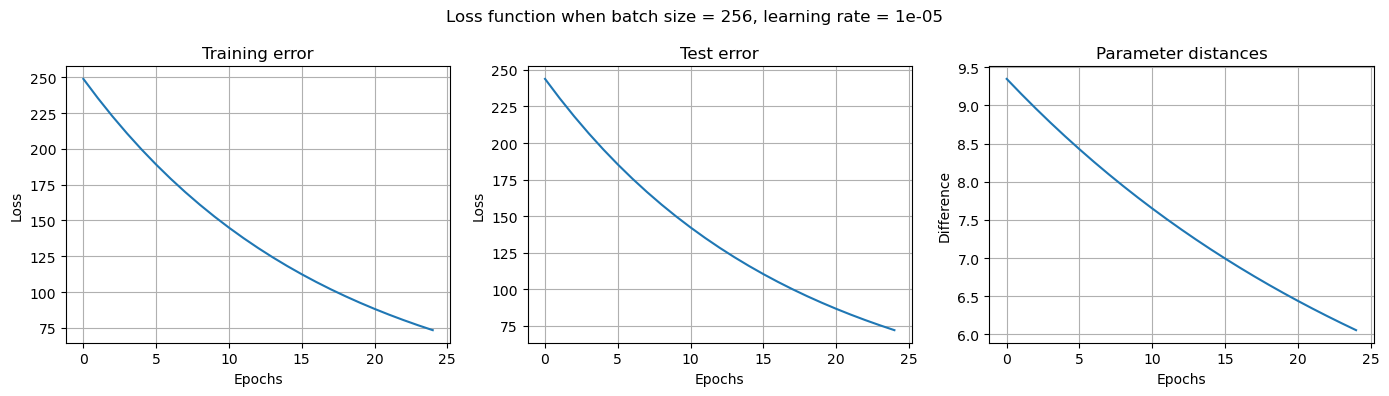

In [38]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle(f"Loss function when batch size = {batch_size}, learning rate = {lr}")
plt.tight_layout()
plt.show()

In [39]:
EPOCHS = 25
online_beta_hat = np.zeros(d+1)
lr = 3e-4
batch_size = 256
print(f"Batch size: {batch_size}")

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    online_beta_hat, train_loss = sgd(batch_size=batch_size, lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Epoch [{epoch+1}]\tLearning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

Batch size: 256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1]	Learning Rate: 0.0003	Train loss: 128.85814	Test loss: 57.89555	Parameter distance: 5.63715


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2]	Learning Rate: 0.0003	Train loss: 34.81910	Test loss: 20.70780	Parameter distance: 4.04897


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3]	Learning Rate: 0.0003	Train loss: 15.01120	Test loss: 10.82387	Parameter distance: 3.20831


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4]	Learning Rate: 0.0003	Train loss: 8.77394	Test loss: 6.99241	Parameter distance: 2.66802


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5]	Learning Rate: 0.0003	Train loss: 6.04144	Test loss: 5.12505	Parameter distance: 2.28575


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6]	Learning Rate: 0.0003	Train loss: 4.62017	Test loss: 4.10446	Parameter distance: 1.99930


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7]	Learning Rate: 0.0003	Train loss: 3.81073	Test loss: 3.50300	Parameter distance: 1.77465


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8]	Learning Rate: 0.0003	Train loss: 3.31739	Test loss: 3.12418	Parameter distance: 1.59149


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9]	Learning Rate: 0.0003	Train loss: 2.99739	Test loss: 2.87060	Parameter distance: 1.43743


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10]	Learning Rate: 0.0003	Train loss: 2.77766	Test loss: 2.69122	Parameter distance: 1.30480


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11]	Learning Rate: 0.0003	Train loss: 2.61923	Test loss: 2.55860	Parameter distance: 1.18871


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12]	Learning Rate: 0.0003	Train loss: 2.50047	Test loss: 2.45711	Parameter distance: 1.08587


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13]	Learning Rate: 0.0003	Train loss: 2.40878	Test loss: 2.37755	Parameter distance: 0.99407


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14]	Learning Rate: 0.0003	Train loss: 2.33645	Test loss: 2.31399	Parameter distance: 0.91160


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15]	Learning Rate: 0.0003	Train loss: 2.27851	Test loss: 2.26261	Parameter distance: 0.83725


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16]	Learning Rate: 0.0003	Train loss: 2.23157	Test loss: 2.22068	Parameter distance: 0.76997


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17]	Learning Rate: 0.0003	Train loss: 2.19322	Test loss: 2.18626	Parameter distance: 0.70900


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18]	Learning Rate: 0.0003	Train loss: 2.16172	Test loss: 2.15787	Parameter distance: 0.65363


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19]	Learning Rate: 0.0003	Train loss: 2.13570	Test loss: 2.13431	Parameter distance: 0.60321


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20]	Learning Rate: 0.0003	Train loss: 2.11412	Test loss: 2.11474	Parameter distance: 0.55735


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21]	Learning Rate: 0.0003	Train loss: 2.09618	Test loss: 2.09844	Parameter distance: 0.51554


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22]	Learning Rate: 0.0003	Train loss: 2.08122	Test loss: 2.08481	Parameter distance: 0.47737


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23]	Learning Rate: 0.0003	Train loss: 2.06873	Test loss: 2.07341	Parameter distance: 0.44253


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24]	Learning Rate: 0.0003	Train loss: 2.05824	Test loss: 2.06383	Parameter distance: 0.41069


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25]	Learning Rate: 0.0003	Train loss: 2.04945	Test loss: 2.05580	Parameter distance: 0.38154


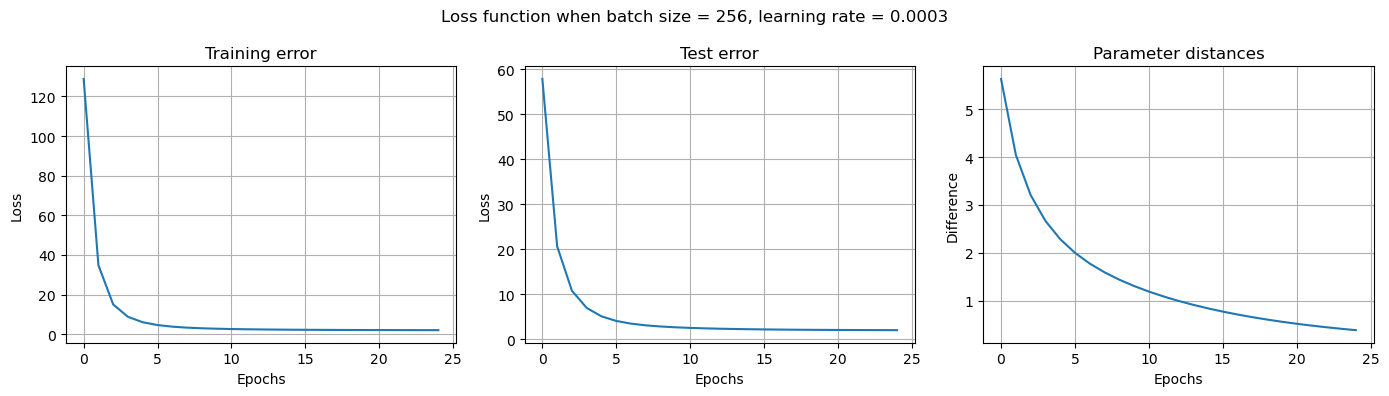

In [40]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.suptitle(f"Loss function when batch size = {batch_size}, learning rate = {lr}")
plt.tight_layout()
plt.show()